# Atividade 1 
Neste trabalho, você terá que entregar um notebook (preferencialmente, um link para um Colab) que implementa um auto-encoder. Para isso:

- Assista aos vídeos de Perceptron e MLP feitos só com numpy. Sua implementação deve seguir o que está lá, porém...
- Sua implementação deve permitir o usuário definir a arquitetura, ou seja, quantas camadas e quantos neurônios em cada uma delas eu vou querer usar. Explique no notebook como é o formato para eu definir isso.
- O notebook deve ter seções e textos explicativos. Ou seja, deve have uma documentação interna.
- Eu testarei com dados sintéticos, como os feitos para as aulas de Perceptron e MLP na prática. Porém, serão melhores (mais atributos, mais intersecção entre os "blobs", etc).


Grupo:

| Nome          | nUSP     |
|---------------|----------|
| Rafael Zimmer | 12542612 |
| Murilo Soave  |          |

In [106]:
import numpy as np
import matplotlib.pyplot as plt

## Definindo o conjunto de dados:

Vamos criar um conjunto de dados sintético para testar o multi-layer perceptron.
Para a atividade, vamos definir uma estrutura que permita multiplas classes e multiplas colunas.

In [107]:
def generate_class(mu, sigma, n):
    return np.random.normal(mu, sigma, n)


def generate_dataset(classes):
    data = []
    for label, params in classes.items():
        n, columns = params
        
        observations_T = []
        
        for mu, sigma in columns:
            observations_T.append(generate_class(mu, sigma, n))
        
        observations = np.array(observations_T).T
        # one hot encoding
        y_true = np.zeros((n, len(classes)))
        y_true[:, label] = 1
        
        data.append(np.concatenate([observations, y_true], axis=1))
    
    sorted_data = np.concatenate(data, axis=0)  
    
    return np.random.permutation(sorted_data)

In [108]:
classes = {
    0: (1000, [(10, 1), (1, 1)]),
    1: (1000, [(5, 1), (0, 1)]),
    2: (1000, [(-1, 1), (-1, 1)]),
    3: (1000, [(-5, 1), (-2, 1)]),
}

In [109]:
data = generate_dataset(classes)
print(data[:5])
print(data.shape)

[[-0.95716528 -0.27431764  0.          0.          1.          0.        ]
 [ 5.33024723  0.03857648  0.          1.          0.          0.        ]
 [ 0.25152195 -0.16732494  0.          0.          1.          0.        ]
 [-1.09833749 -4.06214144  0.          0.          1.          0.        ]
 [10.28906675 -0.43186621  1.          0.          0.          0.        ]]
(4000, 6)


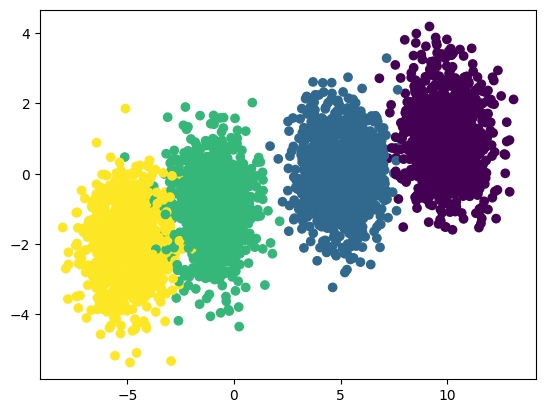

In [110]:
labels = np.argmax(data[:, 2:], axis=1)
plt.scatter(data[:, 0], data[:, 1], c=labels)

In [111]:
from abc import ABC, abstractmethod


class Error(ABC):
    @abstractmethod
    def __call__(self, y_true, y_pred):
        pass
    
    @abstractmethod
    def gradient(self, y_true, y_pred):
        pass


class MSE(Error):
    def __init__(self):
        pass
    
    def __call__(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def gradient(self, y_true, y_pred):
        return 2 * (y_pred - y_true)


class MLP:
    def __init__(self, layers, error: Error = None):
        self.layers = layers
        self.weights = []
        self.biases = []
        self.activations = []
        self.zs = []
        
        if error is None:
            self.error = MSE()
        else:
            self.error = error
        
        for i in range(1, len(layers)):
            self.weights.append(np.random.randn(layers[i-1], layers[i]))
            self.biases.append(np.random.randn(layers[i]))
            self.activations.append(np.tanh)
            self.zs.append(None)
        self.zs.append(None)
        
    def pred(self, x=None, value=None):
        def _to_class(y):
            return np.argmax(y, axis=1)
        if value is not None:
            return _to_class(value)
        elif x is not None:
            return _to_class(self.forward(x))
        else:
            raise ValueError('x or value must be provided')
    
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)
    
    def forward(self, x):
        self.zs[0] = x
        for i in range(len(self.layers) - 1):
            x = np.dot(x, self.weights[i]) + self.biases[i]
            self.zs[i+1] = x
            x = self.activations[i](x)
        return x
    
    def backward(self, x, y):
        y_pred = self.forward(x)
        error = self.error.gradient(y, y_pred)
        for i in range(len(self.layers) - 1, 0, -1):
            error = error * (1 - self.activations[i-1](self.zs[i]) ** 2)
            self.weights[i-1] -= np.dot(self.zs[i-1].T, error)
            self.biases[i-1] -= np.sum(error, axis=0)
            error = np.dot(error, self.weights[i-1].T)
        

In [112]:
# last layer is the output layer so should have same number of neurons as the number of classes
mlp = MLP([2, 3, 4])

y_pred = mlp.forward(data[:, :2])
y_true = data[:, 2:]
pred_labels = mlp.pred(value=y_pred)
labels = np.argmax(y_true, axis=1)

MSE: 1.0475476715925907 Accuracy: 0.20075


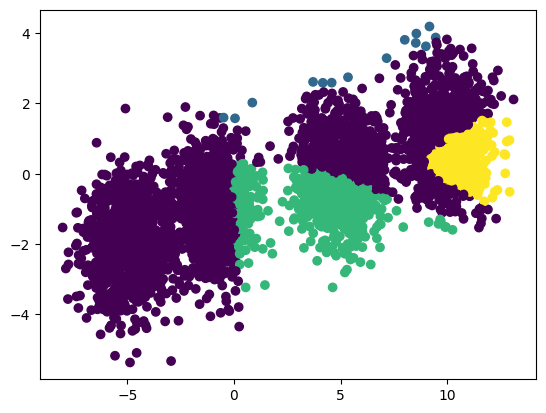

In [113]:
plt.scatter(data[:, 0], data[:, 1], c=pred_labels)
print(
    f'MSE: {mlp.error(y_pred, y_true)}',
    f'Accuracy: {mlp.accuracy(pred_labels, labels)}'
)

In [114]:
gradient = mlp.error.gradient(y_true, y_pred)
print(gradient.shape, y_pred.shape, y_true.shape)
print(gradient)

(4000, 4) (4000, 4) (4000, 4)
[[ 0.56370676 -1.7431188  -3.64176537 -1.8409038 ]
 [ 1.90632177 -1.81301743  1.9005446   1.87652429]
 [ 1.75227369  0.26387968 -0.18838329  1.11506043]
 ...
 [-0.03661154  1.26391868  1.94379181  1.95450318]
 [ 1.48211273  0.39509161 -3.38495593 -1.77414353]
 [-0.83988632 -1.98194234 -3.8761677  -1.94939935]]


In [115]:
print(mlp.weights)
update = mlp.backward(data[:, :2], data[:, 2:])
print(mlp.weights)

[array([[ 2.66569314, -0.24557646,  0.1120186 ],
       [ 0.72396727,  0.9834203 ,  0.39678216]]), array([[ 0.48386741,  0.79824541,  1.39106035,  1.00797451],
       [ 0.43591116,  1.45116438,  0.29719113, -0.15307733],
       [ 1.46055345,  1.51316605,  0.87292359,  1.90553901]])]
[array([[1001213.63387694,  855621.04724261, 2619901.56206241],
       [3205103.91773203,  571923.03077247,  637439.96397519]]), array([[-10481.31552822,   3769.59993985,  -9342.24273236,
         -8044.23456375],
       [  -315.21567409,  -1691.36536046,    181.27085049,
           584.97373103],
       [  -837.77023755,   -158.19997144,   -553.47619284,
          -428.63305855]])]


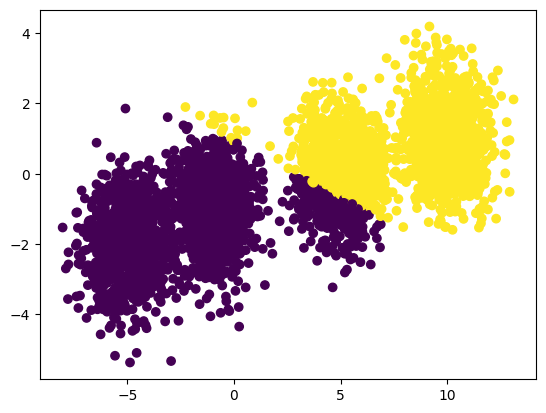

In [116]:
pred_labels = mlp.pred(x=data[:, :2])
labels = np.argmax(data[:, 2:], axis=1)
plt.scatter(data[:, 0], data[:, 1], c=pred_labels)

In [117]:
class Optimizer(ABC):
    @abstractmethod
    def step(self, mlp: MLP, x, y):
        pass

In [118]:
class SGD(Optimizer):
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def step(self, mlp: MLP, x, y):
        y_pred = mlp.forward(x)
        mlp.backward(x, y)

In [122]:
mlp = MLP([2, 3, 4])
sgd = SGD()

acc = -np.inf

for i in range(1000):
    sgd.step(mlp, data[:, :2], data[:, 2:])
    if i % 100 == 0:
        y_pred = mlp.forward(data[:, :2])
        pred_labels = mlp.pred(value=y_pred)
        labels = np.argmax(data[:, 2:], axis=1)
        err = mlp.error(y_pred, data[:, 2:])
        print(
            f'MSE: {mlp.error(y_pred, data[:, 2:])}',
            f'Accuracy: {mlp.accuracy(pred_labels, labels)}'
        )
        
        if acc == 1 or np.isclose(acc, mlp.accuracy(pred_labels, labels)):
            print('Converged')
            break
        acc = mlp.accuracy(pred_labels, labels)


MSE: 1.718 Accuracy: 0.0
MSE: 1.718 Accuracy: 0.0
Converged


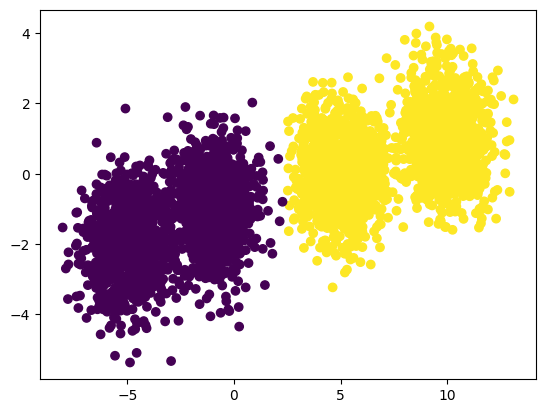

In [123]:
pred_labels = mlp.pred(x=data[:, :2])
labels = np.argmax(data[:, 2:], axis=1)
plt.scatter(data[:, 0], data[:, 1], c=pred_labels)